## 多项式承诺
多项式承诺利用一个度为d的多项式隐藏所谓的秘密，这个秘密可能是多项式的系数，也可能就是$(d+1)$个点.当多项式的度远远小于验证域的阶时候，密码学多年的研究已经证明，可以通过只验证点值的方式就能实现计算意义上的完备性(computational soundness)。显而易见，如果只验证少数几个点值对，计算工作量远远小于验证$(d+1)$个点值对插值求多项式，这也提供了良好的简洁性即succinct。但是简单的利用多项式来实现“通用”、“零知识”等重要的密码学特征，还需要做很多工作。最近几年很火的零知识证明，包括zksnark、zkstark等都是在这个方向上不断探索，并且进展迅速，本文就简单的把多项式承诺的基本概念做一个梳理。

### 多项式点值承诺
承诺生成（Commit）阶段：承诺方选择一个暂不公开的多项式，在某一点r处，计算出对应的承诺c并公开。$c = f(r)$, 将$(r，c)$ 公开给验证方 <br>

承诺披露（Reveal）阶段：承诺方公布多项式，验证方根据多项式计算r处值$c' = f(r)$，比较$c'= c$，一致则表示验证成功，否则失败。

### 实用多项式点值承诺

承诺生成（Commit）阶段：承诺方选择一个暂不公开的多项式，在某一点r处，计算出对应的承诺c并公开。$c = f(r)$, 将$(r，c)$ 公开给验证方 <br>
挑战（challenge）与证明生成：验证方V随机选择一个数z,发给承诺方P, P计算在z处值$s = f(z)$，同时计算出$t(x) = f(x)-s / (x-z)$,计算$t(x)$在z处的值$w = t(z)$,返回给验证方$V(s,w)$ <br>
验证阶段：验证方验证：$s = f(z)$ 等价于 $f(z) - s = 0$ 等价于 方程$f(x)-s = 0$ 有根$x=z$, 即存在$t(x)$ 使得$f(x) - s = t(x)(x - z)$, 这个方程是恒等式，所以任意点都成立。在r处自然也是成立的，所以可以检验$f(r) - s = t(r)(r - z) = c - s = w(r - z )$,通过则验证成功，否则失败。
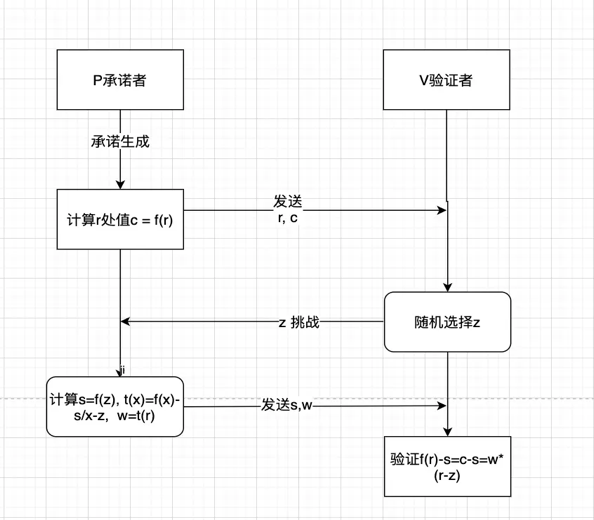

其原理如下：
verifier 验证 $p= t*h$，如果多项式相等，就意味着 $t(x)$ 是 $p(x)$ 的因式。只要P猜中r的概率不超过 𝜀 ,如果这是一个非常小的值，就可以认为这是一个计算意义上的完备，即computational soundness.

#### 存在的问题
prover 可能并不知道他所声称的 $p(x)$，他可以先算一下 $t = t(r)$，然后选择一个随机值 h，由此计算出 $p = t*h$。因为等式是成立的，所以也能通过 verifier 的校验。
因为 prover 知道随机点 $x = r $，他可以构造出一个任意的多项式，这个任意多项式与 $t(r) * h(r)$ 在 r 处有共同点。
在前面的「陈述」中，prover 声称他知道一个特定阶数的多项式，但现在的协议对阶数并没有明确的要求。因而 prover 完全可以拿一个满足因式校验的更高阶数的多项式来欺骗 verifier。

所以对这个算法改进的方向在两点：1证明方不可以直接得到验证者查询的随机数 2必须约束这个多项式的阶数在一定范围之内

### PCP和PCPP

密码学一个里程碑的贡献是Probabilistically checkable proofs of proximity，作者因此获得了图灵奖，有兴趣可以去搜一下。本文简单描述其原理，所有的NP问题，都可以在多项式时间内通过概率验证的方法被证明。这是因为所有的NP类问题，都可以归约到数学运算电路，这种归约的思路在NP类领域有一个非常有名的概念叫NPC（NP完全问题），数学上已经证明，所有的NP类问题都可以归约到少数几个NPC问题，PCP定理通过对数学运算电路这个NPC问题的研究，证明了这个现代密码学的基石理论。那什么叫概率验证呢？其实我们可以把它理解为随机抽查：如果A有一个很复杂的问题的解，但是这个解很长很长，那么B就可以通过随机抽查这个解的某几位来大概确定A的解是否准确。因为A不知道B会抽查哪一位，所以A没有任何有利的方法作弊，B每抽查验证成功一次，A的解是错误的解的可能性就下降一次。具体而言，Prover需要额外提供一个proof，verifier通过查询来判断prover是否作弊。根据不同的场景，这个proof可能是一个椭圆曲线上的公钥，也可能是多项式计算的一个结果。Verifer通过常数次查询，就能概率性判断Prover是否作弊，例如在zksnark里，verifier能通过一次查询就能判断prover的作弊的可能性  <𝜀 .

### LPCP
PCP其实是一个非常笼统的定理，只是证明了NP范围内的问题可以通过随机抽验的方法来验证，但是并没有详细说明这个证明到底是什么，也没有讲明白具体抽验的过程。纯粹依赖于PCP猜数字抽查的效率非常低，生成一个问题的证明，可能就要花费半天时间。这对于我们在网络上的应用场景来说非常不现实。为了更加高效率的生成简短证明，我们要对PCP问题进行进一步的约束。LPCP即线性PCP，源自于PCP，但是对于PCP所描述的问题又加了一个约束：线性PCP（Linear PCP/LPCP）。<br>
LPCP是构成下文中Kate承诺和Zksnark算法的核心。简单的说一下它的基本原理，通过定义 $$ L(x) . R(x) = O(x) $$ 将此多项式转换为 $$ L(x).R(x)-O(x) = 0 $$ 证明者需要向验证者证明它知道这个方程有$[1,2,...d]$ 根，换而言之，$L(x).R(x)-O(x) / t(x) $ 可以得到一个多项式，这就是所谓的线性约束的由来，其中 $t(x)=(x-1)(x-2)...(x-d)$。当然这里构造 $L(x).R(x)-O(x)$ 这样的多项式，并不是LPCP所必须要求的，这是因为LPCP主要出现在Zksnark的R1CS电路中，$L(x).R(x)$其实就是对应于R1CS的一阶的运算符。

### KATE/KZG承诺
kate承诺其实就是LPCP的一种具体实现形式，zksnark用到的就是kate承诺，简单的说，其核心原理就是通过构造椭圆曲线有限域上的多项式，如果验证的多项式的度远远小于有限域的阶，就能满足上面PCP的条件。要注意2点，第一因为我们构造的椭圆曲线有限域本质上是一个加法群，不支持多项式计算的结果（本质上是一个点，或者说是一个标量）的乘法，所以特别构造了一个配对函数，用以支持同态的“乘法”验证，其次为了构造验证多项式的“陷门”，即所谓trapdoor，需要根据不同的多项式构造不同的陷门参数，这就是所谓的CRS，需要提前设置，也是一个被攻击不够抗审查的地方。具体原理需要专门的文章，这里就不展开了。


### FRI承诺的基本原理
从一个常数函数开始 $ f(x) = 3 $ prover宣称自己知道类似于上面的一个函数，虽然此时看起来很naive，很直接，但从此衍生出来的问题和解决方案将是stark的基础  <br>

第一步commit阶段，prover 提交一个commitment，c=3，一个随机的v，其中c要保存在一个中间方，例如区块链的智能合约里，可称之为oracle，以免篡改  <br>

第二步open或reveal阶段，verifier 向prover（或者oracle）查询一个随机数r的运行结果q，同时prover向verifier披露v  <br>

在此时，verifier验证$ q ==? c $ 因为verifier事先知道prover要证明的是一个阶(degree)小于1，其实就是0，常数函数，以上验证结果立即可以得到这个函数。当要验证函数是一个1阶的函数时，例如
$ f(x) = 3x + 1 $ 把$f(x)$改写为$ f(x) = f_e(x^2) + x*f_o(x^2) $ 其中$ f_e(x) = 1, f_o(x) = 3 $如果我们能够分别证明，$ f_e(x), f_o(x) $ 的阶小于1(就是一个常数)，我们就间接证明了$f(x)$的阶是小于2的。<br> 
此时prover和verifier有两次commit和query的交互，第一次commit，假定v=3, 则c=10，第二次commit，(1,3)；verifier用上面的方法分别验证即可。但此时有一个技巧，通过定义一个新的函数 $ f_2(y) = f_e(y) + \beta * f_o(y) $ 其中 $ \beta $ 是一个随机数，由verifier提供给oracle或者prover，通过验证这个新的函数是常数函数，可以立即证明原函数是阶小于2的多项式函数。这个技巧非常像FFT（快速傅里叶变换）的数学方法，以此类推，通过多次交互，验证一个阶degree < n的多项式函数。这个方法的核心发展成为FRI，是ZKSTARK、plonky等零知识证明用到的关键技术

### 实现 PC 的方案有很多种：

KZG10 Commitment ：基于pairing group
IPA Commitment：基于discrete log group
FRI Commitment：基于hash function
DARKS Commitment：基于 unknown order group
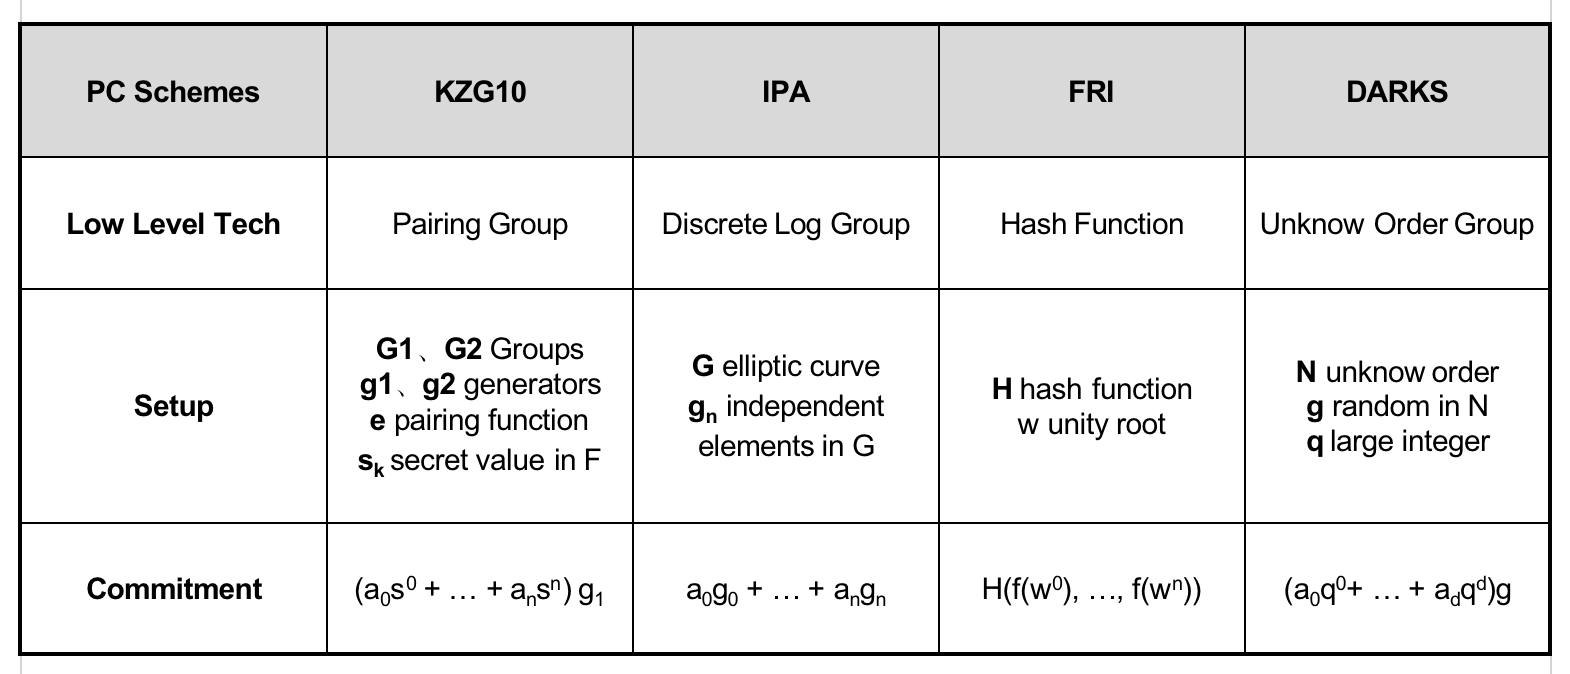
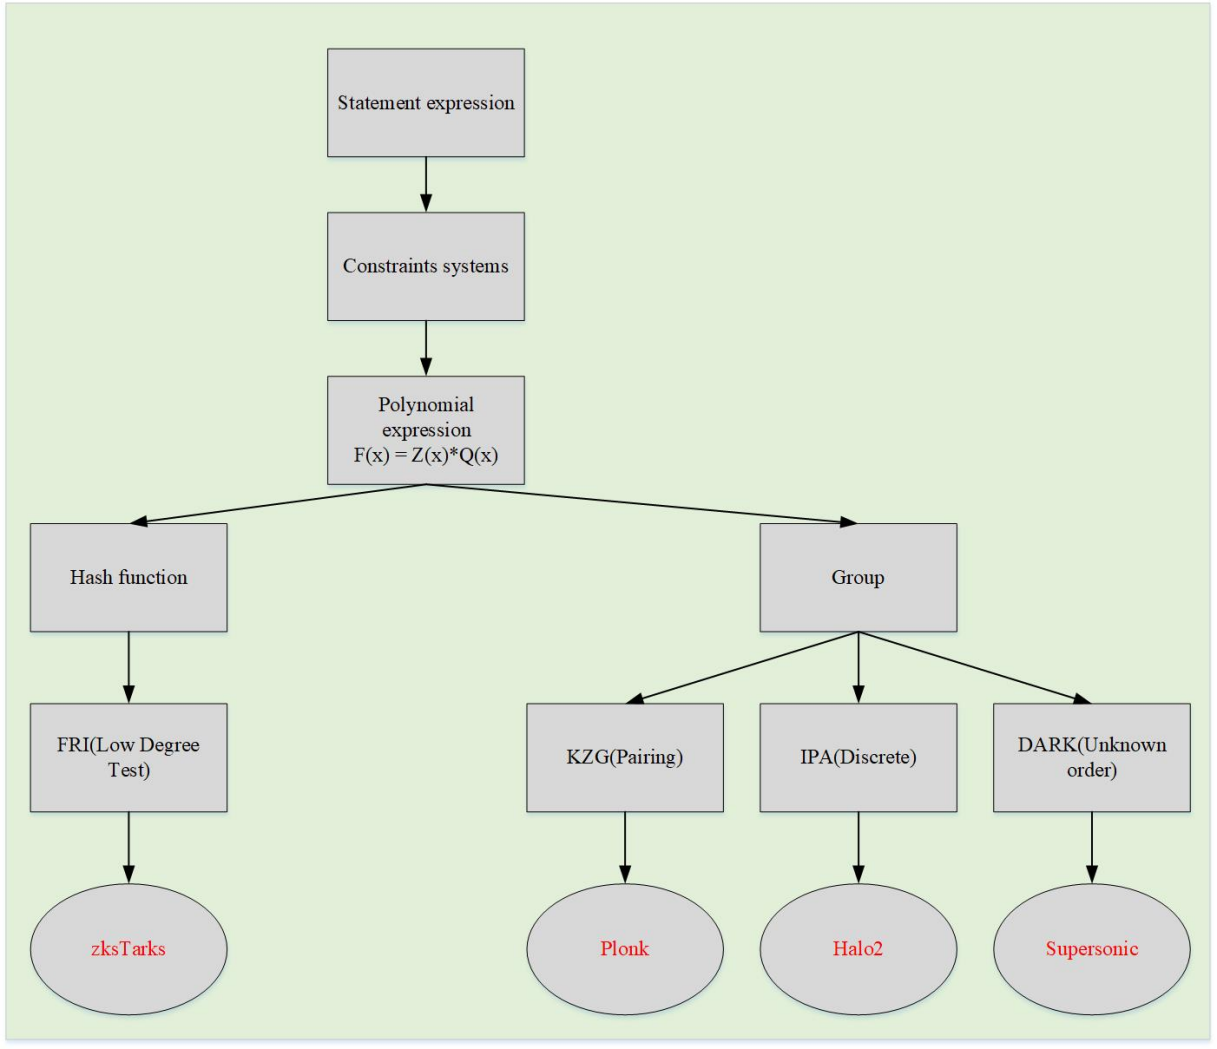
不同的 PC 方案，导致不同的零知识证明算法具有不同的性质，在效率和安全性上也有明显的区别。比如，以 FRI 为基础的 zk-STARKs 算法，由于其依赖很少的数学安全假设，因此是抗量子的，且不需要任何可信设置；

再者，以 DARK 为基础的 Supersonic 算法，如果 unknown order group 是 RSA Group，则是需要可信设置的，依赖大数分解困难性假设；如果是 Class Group，则是不需要可信设置的，依赖计算 Class Group 元素数量的困难性。下面，我们仍然以一个表格的形式对比下，每个 PC 的优缺点：
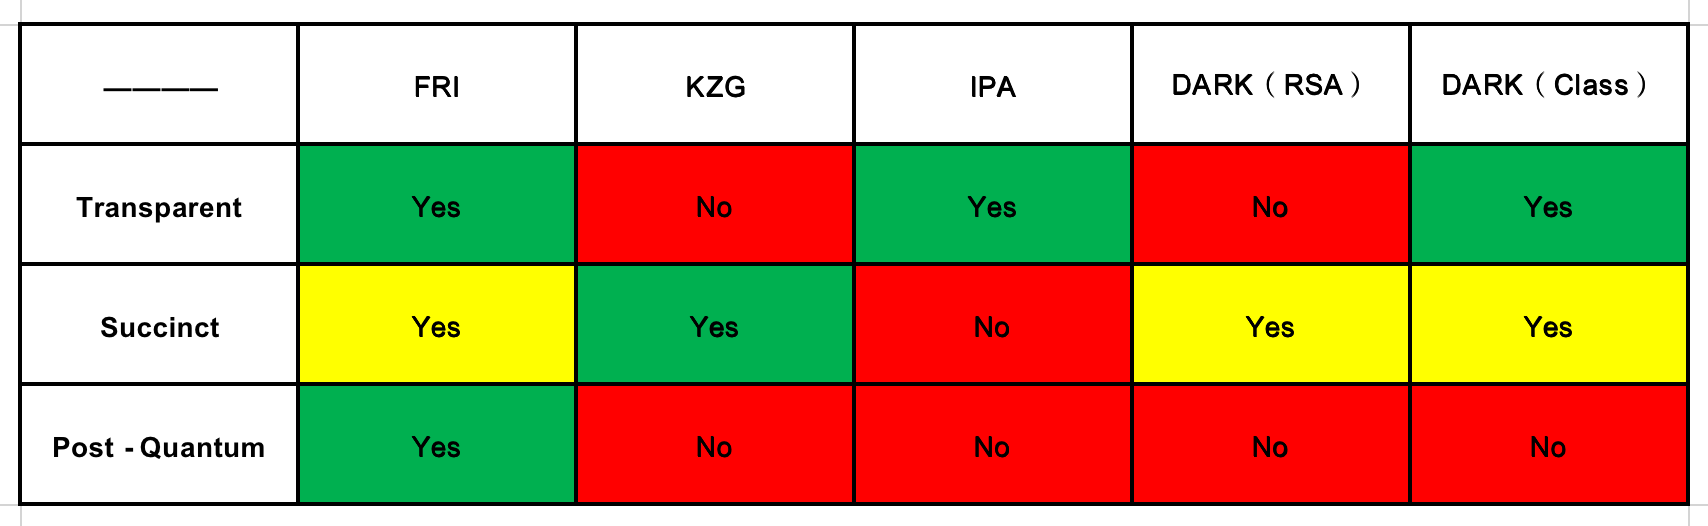
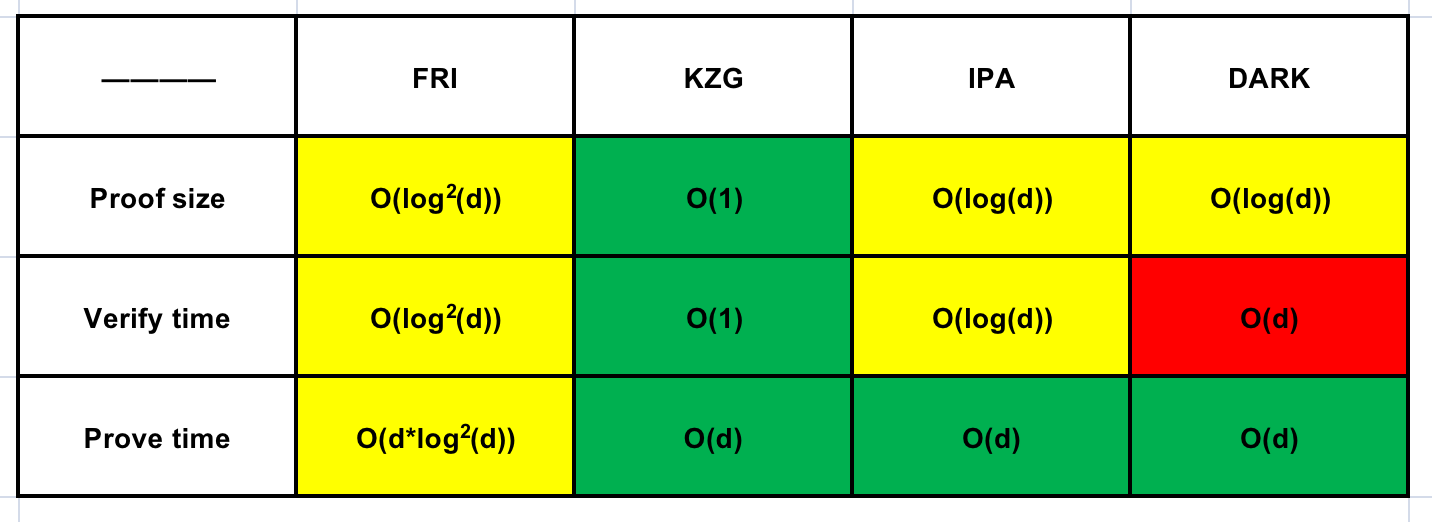
从表格中可以看出，从 Succinct 角度评比，KZG 方案最佳；它的证明大小和验证时间都是常量级，也就是说 Circuit 的 size 增大，不会导致 Proof size 的增大；而其他的 PC 方案，Proof size的大小，都与 circuit 规模有关，且为递增关系。但是，从安全性角度分析，KZG 的方案由于需要第三方的可信设置（参见表 1），因此相对于其他的方案，安全性弱一些。


